# Quickstart Example with Synthetic RTB Simulation and Dataset (Continuous)
This notebook provides an example of conducting **Off-policy Evaluation (OPE) and Offline Reinforcement Learning (Offline RL) with synthetic Real-Time Bidding (RTB) dataset**.

Our example with Synthetic RTB Simualtion and Dataset contains the following 5 steps:
0. (Setup Synthetic RTB Simulation Environment and Online RL)
1. Synthetic Data Generation
2. Offline Reinforcement Learning
3. Off-Policy Evaluation and Evaluation of Offline RL methods
4. Evaluation of OPE methods

We also show how to visualize the results in Appendix.

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations of online/offline rl policies and model-based evaluation.  
\* Also, our implementations of OPE are highly inspired by [Open Bandit Pipeline](https://github.com/st-tech/zr-obp).

In [1]:
# delete later
%load_ext autoreload
%autoreload 2

In [2]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [3]:
# delete later
import sys
sys.path.append('../')
sys.path.append('../../')

In [4]:
# import _gym modules
import _gym
from _gym.env import RTBEnv, CustomizedRTBEnv
from _gym.dataset import SyntheticDataset
from _gym.policy import OnlineHead, ContinuousTruncatedGaussianHead
from _gym.ope.online import (
    calc_on_policy_policy_value,
    visualize_on_policy_policy_value,
)

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy
from d3rlpy.algos import RandomPolicy as ContinuousRandomPolicy
from d3rlpy.preprocessing import MinMaxActionScaler

# import from other libraries
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [5]:
import pickle
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [6]:
# version
print(_gym.__version__)

0.0.0


In [7]:
# set random state
random_state = 12345

In [8]:
# log directory
from pathlib import Path
Path("logs/").mkdir(exist_ok=True)

## 0. (Setup Synthetic RTB Simulation Environment and Online RL)
To begin with, we briefly describe how the RTB environment works for the preparation.

#### RL setup for RTB
In RTB, the objective of the RL agent is to maximize some KPIs (such as numbers of click or conversion) within a episode under the given budget constraints.  
We often try to achieve this by adjusting bidding price function parameter $\alpha$. By using $\alpha$, we adjust bid price as follows.  
$bid_{t,i} = \alpha \cdot r^{\ast}$, 
where $r^{\ast}$ denotes predicted or expected reward (KPIs).

We often formulate this RTB problem as the following Constrained Markov Decision Process (CMDP):
- `timestep`: One episode (a day or a week) consists of several timesteps (24 hours or seven days, for instance).
- `state`: We observe statistical feedback from environment at each timestep, which include following informations.
  - timestep
  - remaining budget
  - impression level features (budget comsuption rate, cost per mille of impressions, auction winning rate, reward) at previous timestep
  - adjust rate (RL agent's decision making) at previous timestep
- `action`: Agent chooses adjust rate parameter $\alpha$ to maximize KPIs.
- `reward`: Total number of clicks or conversions obtained during the timestep.
- `constraints`: The pre-determined episodic budget should not be exceeded.

Let's see how it works!

In [9]:
# setup environment
env = RTBEnv(random_state=random_state)

In [10]:
# define random agent
agent = OnlineHead(
    ContinuousRandomPolicy(
        action_scaler=MinMaxActionScaler(
            minimum=0.1,  # minimum value that policy can take
            maximum=10,  # maximum value that policy can take
        )
    )
)

In [11]:
# interact agent with environment
# only 6 lines needed for RL interaction
for episode in range(10):
    obs = env.reset()
    done = False

    while not done:
        action = agent.predict_online(obs)
        obs, reward, done, info = env.step(action)

In [12]:
# state contains the following statistical feedback from environment
print(env.obs_keys)
print(obs.shape)

['timestep', 'remaining_budget', 'budget_consumption_rate', 'cost_per_mille_of_impression', 'winning_rate', 'reward', 'adjust_rate']
(7,)


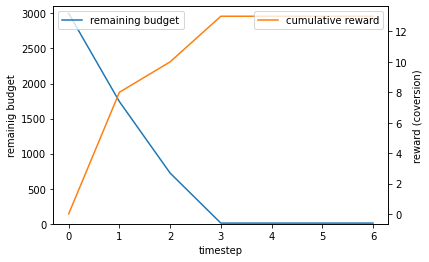

In [13]:
# let's visualize the transition of remaing budget and cumulative reward
# our goal is to gain a policy (i.e., agent) which maximize the cumulative reward under budget constraints using RL.  
# for more visulization, please see appendix.
obs = env.reset()
done = False
remaining_budget = [obs[1]]
cumulative_reward = [0]

while not done:
    action = agent.predict_online(obs)
    obs, reward, done, info = env.step(action)
    remaining_budget.append(obs[1])
    cumulative_reward.append(cumulative_reward[-1] + reward)

# plot
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(remaining_budget[:-1], label='remaining budget')
ax2 = ax1.twinx()
ax2.plot(cumulative_reward[:-1], label='cumulative reward', color='tab:orange')
ax1.set_xlabel('timestep')
ax1.set_ylabel('remainig budget')
ax1.set_ylim(0, env.initial_budget + 100)
ax2.set_ylabel('reward (coversion)')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.show()

We see that the random policy soon run out the budget.  
Our goal is to derive a policy that controls the adjust rate (i.e., action) to maximize the reward within the given budget constraints.

For the customization of environmental configuration (e.g., WinningPriceDistribution) and visualization, please refer to `rtb_synthetic_customize_environment.ipynb`.

#### Customization of bidding setup in RTB Env
Here, we describe how the decision makers customize their own RTB environment.  
Specifically, they can setup their own action space and bid price calculation rules by defining the following modules.
- `reward_predictor` in Bidder class  
    We use predicted rewards to calculate bid price.  
        bid price = adjust rate * predicted reward ( * constant)
    If None, we use ground-truth reward instead of predicted reward.  

- `scaler` in Bidder class
    Scaler defines constant in the bid price calculation.  
        bid price = adjust rate * predicted reward ( * constant)
        constant = scaler * standard_bid_price
    where standard_bid_price indicates the average of standard_bid_price  
    (bid price which has approximately 50% impression probability) over all ads.

- `action_space` for agent  
    We transform continual adjust rate space $[0, \infty)$ into agent action space $[0.1, 10]$.  
    Both discrete and continuous actions are acceptable.  
    (We can tune multiplication of adjust rate using scaler.)
    
The arguments are given as follows:
- `original_env`: Original RTB Environment.
- `reward_predictor`: A machine learning model to predict the reward to determine the bidding price.
- `scaler`: Scaling factor (constant value) used for bid price determination. (`None` for the auto-fitting)
- `action_min`: Minimum value of adjust rate.
- `action_max`: Maximum value of adjust rate.
- `action_type`: Action type of the RL agent, which is either "discrete" or "continuous".
- `n_actions`: Number of "discrete" actions.
- `action_meaning`: Mapping function of agent action index to the actual "discrete" action to take.

In [14]:
# now, let's customize the environment with reward predictor
env = CustomizedRTBEnv(
    original_env=env,
    reward_predictor=LogisticRegression(),
    action_type="continuous",
)

In [15]:
# interact agent with environment
for episode in range(10):
    obs = env.reset()
    done = False

    while not done:
        action = agent.predict_online(obs)
        obs, reward, done, info = env.step(action)

In [16]:
print(env.action_space)

Box(0.1, 10.0, (1,), float64)


#### Online RL and comparison of the policies
We now learn an online RL policy and compare it to random policy, using on-policy policy estimation.

In [17]:
from d3rlpy.algos import SAC
from d3rlpy.models.encoders import VectorEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from d3rlpy.online.buffers import ReplayBuffer

# model
sac = SAC(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,   # 0.1
        maximum=env.action_space.high,  # 10
    ),
)
# setup replay buffer
buffer = ReplayBuffer(
    maxlen=10000,
    env=env,
)

In [17]:
# start training
# skip if there is a pre-trained model
sac.fit_online(
    env,
    buffer,
    eval_env=env,
    n_steps=100000,
    n_steps_per_epoch=1000,
)

2021-12-10 19:18.31 [info     ] Directory is created at d3rlpy_logs/SAC_online_20211210191831
2021-12-10 19:18.31 [debug    ] Fitting action scaler...       action_scler=min_max
2021-12-10 19:18.31 [debug    ] Building model...
2021-12-10 19:18.31 [debug    ] Model has been built.
2021-12-10 19:18.31 [info     ] Parameters are saved to d3rlpy_logs/SAC_online_20211210191831/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 100, 'critic_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense'

  1%|          | 989/100000 [00:05<10:10, 162.11it/s]

2021-12-10 19:18.37 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_1000.pt
2021-12-10 19:18.37 [info     ] SAC_online_20211210191831: epoch=1 step=1000 epoch=1 metrics={'time_inference': 0.0005520493984222413, 'time_environment_step': 0.0006707829066685268, 'time_step': 0.0059059979915618895, 'time_sample_batch': 0.00013524745143739518, 'time_algorithm_update': 0.00517546901595121, 'temp_loss': -6.203896491372653, 'temp': 1.0307030244062176, 'critic_loss': 1993.604321336477, 'actor_loss': 19.38410457136941, 'evaluation': 15.3} step=1000


  2%|▏         | 1990/100000 [00:12<10:08, 161.04it/s]

2021-12-10 19:18.44 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_2000.pt
2021-12-10 19:18.44 [info     ] SAC_online_20211210191831: epoch=2 step=2000 epoch=2 metrics={'time_inference': 0.0005333716869354248, 'time_environment_step': 0.0006286457606724331, 'time_sample_batch': 0.0001303226947784424, 'time_algorithm_update': 0.004960209846496582, 'temp_loss': -2.8506151375770568, 'temp': 1.102654072880745, 'critic_loss': 109.09293706893921, 'actor_loss': 10.348633473396301, 'time_step': 0.006236335754394531, 'evaluation': 14.8} step=2000


  3%|▎         | 2995/100000 [00:18<10:03, 160.67it/s]

2021-12-10 19:18.50 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_3000.pt
2021-12-10 19:18.50 [info     ] SAC_online_20211210191831: epoch=3 step=3000 epoch=3 metrics={'time_inference': 0.0005353047847747803, 'time_environment_step': 0.0006291212354387556, 'time_sample_batch': 0.00013408923149108885, 'time_algorithm_update': 0.004945097923278808, 'temp_loss': -3.3752625741958617, 'temp': 1.2727824336290359, 'critic_loss': 145.95702727890014, 'actor_loss': 11.831354211330414, 'time_step': 0.006227325916290283, 'evaluation': 14.4} step=3000


  4%|▍         | 3999/100000 [00:25<10:09, 157.55it/s]

2021-12-10 19:18.56 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_4000.pt
2021-12-10 19:18.57 [info     ] SAC_online_20211210191831: epoch=4 step=4000 epoch=4 metrics={'time_inference': 0.0005454394817352295, 'time_environment_step': 0.0006531671796526228, 'time_sample_batch': 0.0001414201259613037, 'time_algorithm_update': 0.005105823278427124, 'temp_loss': -4.39955700814724, 'temp': 1.6191414535045623, 'critic_loss': 226.98308086395264, 'actor_loss': 16.113335766792297, 'time_step': 0.006429171323776245, 'evaluation': 16.1} step=4000


  5%|▍         | 4983/100000 [00:31<09:53, 160.12it/s]

2021-12-10 19:19.03 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_5000.pt
2021-12-10 19:19.03 [info     ] SAC_online_20211210191831: epoch=5 step=5000 epoch=5 metrics={'time_inference': 0.0005346136093139648, 'time_environment_step': 0.0006507175990513393, 'time_sample_batch': 0.0001418492794036865, 'time_algorithm_update': 0.005027872562408447, 'temp_loss': -6.147951650023461, 'temp': 2.22727242064476, 'critic_loss': 431.0214639892578, 'actor_loss': 24.075120285987854, 'time_step': 0.006337780952453614, 'evaluation': 15.7} step=5000


  6%|▌         | 5984/100000 [00:38<09:40, 161.88it/s]

2021-12-10 19:19.09 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_6000.pt
2021-12-10 19:19.09 [info     ] SAC_online_20211210191831: epoch=6 step=6000 epoch=6 metrics={'time_inference': 0.0005235669612884521, 'time_environment_step': 0.000621678216116769, 'time_sample_batch': 0.0001369619369506836, 'time_algorithm_update': 0.004905898571014405, 'temp_loss': -8.462501155853271, 'temp': 3.192302245616913, 'critic_loss': 863.5636893310547, 'actor_loss': 36.496166706085205, 'time_step': 0.006172085285186767, 'evaluation': 17.7} step=6000


  7%|▋         | 6995/100000 [00:44<12:36, 122.89it/s]

2021-12-10 19:19.16 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_7000.pt
2021-12-10 19:19.16 [info     ] SAC_online_20211210191831: epoch=7 step=7000 epoch=7 metrics={'time_inference': 0.000543262243270874, 'time_environment_step': 0.0006593208312988281, 'time_sample_batch': 0.0001454629898071289, 'time_algorithm_update': 0.0050814757347106936, 'temp_loss': -12.407233408212662, 'temp': 4.612883499622345, 'critic_loss': 1832.987744934082, 'actor_loss': 55.26804504776001, 'time_step': 0.0064123978614807125, 'evaluation': 15.3} step=7000


  8%|▊         | 7987/100000 [00:51<09:51, 155.51it/s]

2021-12-10 19:19.22 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_8000.pt
2021-12-10 19:19.22 [info     ] SAC_online_20211210191831: epoch=8 step=8000 epoch=8 metrics={'time_inference': 0.0005304443836212158, 'time_environment_step': 0.0006278397696358817, 'time_sample_batch': 0.00014062094688415528, 'time_algorithm_update': 0.00498258113861084, 'temp_loss': -18.155231479644776, 'temp': 6.756919405937195, 'critic_loss': 3907.175770385742, 'actor_loss': 83.15271133041382, 'time_step': 0.006265402555465698, 'evaluation': 14.6} step=8000


  9%|▉         | 8985/100000 [00:57<10:17, 147.29it/s]

2021-12-10 19:19.29 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_9000.pt
2021-12-10 19:19.29 [info     ] SAC_online_20211210191831: epoch=9 step=9000 epoch=9 metrics={'time_inference': 0.0005390865802764892, 'time_environment_step': 0.0006496295928955078, 'time_sample_batch': 0.0001462385654449463, 'time_algorithm_update': 0.005136591672897339, 'temp_loss': -26.816532811880112, 'temp': 9.893889910697936, 'critic_loss': 8427.46709814453, 'actor_loss': 124.79171171569824, 'time_step': 0.006455745935440064, 'evaluation': 13.4} step=9000


 10%|▉         | 9993/100000 [01:04<09:27, 158.55it/s]

2021-12-10 19:19.36 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_10000.pt
2021-12-10 19:19.36 [info     ] SAC_online_20211210191831: epoch=10 step=10000 epoch=10 metrics={'time_inference': 0.0005471990108489991, 'time_environment_step': 0.0006503636496407645, 'time_sample_batch': 0.00014783668518066406, 'time_algorithm_update': 0.00510456919670105, 'temp_loss': -37.951701217412946, 'temp': 14.45835704612732, 'critic_loss': 17001.045852050782, 'actor_loss': 180.1661346588135, 'time_step': 0.006435108184814453, 'evaluation': 12.5} step=10000


 11%|█         | 10997/100000 [01:10<08:47, 168.75it/s]

2021-12-10 19:19.42 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_11000.pt
2021-12-10 19:19.42 [info     ] SAC_online_20211210191831: epoch=11 step=11000 epoch=11 metrics={'time_inference': 0.0005175826549530029, 'time_environment_step': 0.0006065483093261718, 'time_sample_batch': 0.0001404290199279785, 'time_algorithm_update': 0.004886785507202149, 'temp_loss': 12.399086994927377, 'temp': 16.884381923675537, 'critic_loss': 4951.961453491211, 'actor_loss': 69.28386824595928, 'time_step': 0.006136190891265869, 'evaluation': 14.6} step=11000


 12%|█▏        | 11989/100000 [01:17<09:13, 158.95it/s]

2021-12-10 19:19.48 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_12000.pt
2021-12-10 19:19.48 [info     ] SAC_online_20211210191831: epoch=12 step=12000 epoch=12 metrics={'time_inference': 0.0005379197597503662, 'time_environment_step': 0.0006363432747977121, 'time_sample_batch': 0.00014758753776550294, 'time_algorithm_update': 0.005047565221786499, 'temp_loss': 20.215919610619544, 'temp': 13.640398648262025, 'critic_loss': 407.1304658203125, 'actor_loss': -8.552717673053966, 'time_step': 0.006356300830841065, 'evaluation': 15.5} step=12000


 13%|█▎        | 12997/100000 [01:23<09:16, 156.45it/s]

2021-12-10 19:19.55 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_13000.pt
2021-12-10 19:19.55 [info     ] SAC_online_20211210191831: epoch=13 step=13000 epoch=13 metrics={'time_inference': 0.0005333094596862793, 'time_environment_step': 0.0006457118988037109, 'time_sample_batch': 0.0001466083526611328, 'time_algorithm_update': 0.005036045551300048, 'temp_loss': 16.402711869239806, 'temp': 10.814217313766479, 'critic_loss': 133.81520588684083, 'actor_loss': -21.64075915145874, 'time_step': 0.006350154161453247, 'evaluation': 17.5} step=13000


 14%|█▍        | 13990/100000 [01:30<08:46, 163.23it/s]

2021-12-10 19:20.01 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_14000.pt
2021-12-10 19:20.01 [info     ] SAC_online_20211210191831: epoch=14 step=14000 epoch=14 metrics={'time_inference': 0.0005147652626037597, 'time_environment_step': 0.0006068022591727121, 'time_sample_batch': 0.00014081954956054687, 'time_algorithm_update': 0.004905359268188476, 'temp_loss': 12.768777104616165, 'temp': 8.624682576179504, 'critic_loss': 107.89201851081849, 'actor_loss': -19.043983912706373, 'time_step': 0.006155072450637817, 'evaluation': 13.9} step=14000


 15%|█▍        | 14993/100000 [01:36<08:48, 160.86it/s]

2021-12-10 19:20.08 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_15000.pt
2021-12-10 19:20.08 [info     ] SAC_online_20211210191831: epoch=15 step=15000 epoch=15 metrics={'time_inference': 0.0005100290775299072, 'time_environment_step': 0.000597893306187221, 'time_sample_batch': 0.00013899970054626464, 'time_algorithm_update': 0.004878754377365112, 'temp_loss': 10.304577405631543, 'temp': 6.903750758647918, 'critic_loss': 63.42510566520691, 'actor_loss': -16.3898885846138, 'time_step': 0.0061126558780670165, 'evaluation': 14.4} step=15000


 16%|█▌        | 15991/100000 [01:42<09:32, 146.74it/s]

2021-12-10 19:20.14 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_16000.pt
2021-12-10 19:20.14 [info     ] SAC_online_20211210191831: epoch=16 step=16000 epoch=16 metrics={'time_inference': 0.0005448889732360839, 'time_environment_step': 0.0006592864990234375, 'time_sample_batch': 0.00015117120742797851, 'time_algorithm_update': 0.005174391269683838, 'temp_loss': 8.466666707038879, 'temp': 5.5058891363143925, 'critic_loss': 37.80306273651123, 'actor_loss': -14.557545587539673, 'time_step': 0.006517716646194458, 'evaluation': 13.7} step=16000


 17%|█▋        | 16985/100000 [01:49<08:55, 155.06it/s]

2021-12-10 19:20.21 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_17000.pt
2021-12-10 19:20.21 [info     ] SAC_online_20211210191831: epoch=17 step=17000 epoch=17 metrics={'time_inference': 0.0005425982475280762, 'time_environment_step': 0.0006656802041190011, 'time_sample_batch': 0.00015209197998046874, 'time_algorithm_update': 0.005146168947219849, 'temp_loss': 6.56696987336874, 'temp': 4.408480725526809, 'critic_loss': 29.619025358200073, 'actor_loss': -11.78302618598938, 'time_step': 0.006496001720428466, 'evaluation': 13.8} step=17000


 18%|█▊        | 17994/100000 [01:56<08:21, 163.41it/s]

2021-12-10 19:20.27 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_18000.pt
2021-12-10 19:20.27 [info     ] SAC_online_20211210191831: epoch=18 step=18000 epoch=18 metrics={'time_inference': 0.0005168466567993164, 'time_environment_step': 0.0006157779693603516, 'time_sample_batch': 0.00014273548126220704, 'time_algorithm_update': 0.0049707677364349365, 'temp_loss': 5.380283036112785, 'temp': 3.5258183169364927, 'critic_loss': 16.983838385105134, 'actor_loss': -10.6877344455719, 'time_step': 0.006233031034469604, 'evaluation': 13.2} step=18000


 19%|█▉        | 18994/100000 [02:02<08:52, 152.13it/s]

2021-12-10 19:20.34 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_19000.pt
2021-12-10 19:20.34 [info     ] SAC_online_20211210191831: epoch=19 step=19000 epoch=19 metrics={'time_inference': 0.000542478084564209, 'time_environment_step': 0.0006598671504429408, 'time_sample_batch': 0.00015029263496398927, 'time_algorithm_update': 0.005135777473449707, 'temp_loss': 4.255918775558472, 'temp': 2.819159589290619, 'critic_loss': 14.158411615848541, 'actor_loss': -9.259546101570129, 'time_step': 0.006476867198944092, 'evaluation': 15.0} step=19000


 20%|█▉        | 19986/100000 [02:09<08:59, 148.21it/s]

2021-12-10 19:20.41 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_20000.pt
2021-12-10 19:20.41 [info     ] SAC_online_20211210191831: epoch=20 step=20000 epoch=20 metrics={'time_inference': 0.0005424010753631592, 'time_environment_step': 0.0006587456294468472, 'time_sample_batch': 0.00015075945854187012, 'time_algorithm_update': 0.005181850671768189, 'temp_loss': 3.425988456480205, 'temp': 2.2582494428157807, 'critic_loss': 10.562403022527695, 'actor_loss': -8.213860537528992, 'time_step': 0.006521210432052612, 'evaluation': 13.6} step=20000


 21%|██        | 20983/100000 [02:16<08:09, 161.39it/s]

2021-12-10 19:20.47 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_21000.pt
2021-12-10 19:20.47 [info     ] SAC_online_20211210191831: epoch=21 step=21000 epoch=21 metrics={'time_inference': 0.0005566198825836181, 'time_environment_step': 0.0006651853833879744, 'time_sample_batch': 0.00015158247947692871, 'time_algorithm_update': 0.00529474139213562, 'temp_loss': 2.6978448156118393, 'temp': 1.8081099630594253, 'critic_loss': 9.117015995502472, 'actor_loss': -7.237104878902436, 'time_step': 0.00665586543083191, 'evaluation': 15.4} step=21000


 22%|██▏       | 21990/100000 [02:22<08:20, 156.00it/s]

2021-12-10 19:20.54 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_22000.pt
2021-12-10 19:20.54 [info     ] SAC_online_20211210191831: epoch=22 step=22000 epoch=22 metrics={'time_inference': 0.0005178935527801514, 'time_environment_step': 0.0006100066048758371, 'time_sample_batch': 0.00014055228233337402, 'time_algorithm_update': 0.00496433424949646, 'temp_loss': 2.191360368642956, 'temp': 1.4501593644618989, 'critic_loss': 7.185327352762222, 'actor_loss': -6.633585884094238, 'time_step': 0.006219345331192017, 'evaluation': 14.3} step=22000


 23%|██▎       | 22985/100000 [02:29<07:47, 164.67it/s]

2021-12-10 19:21.00 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_23000.pt
2021-12-10 19:21.00 [info     ] SAC_online_20211210191831: epoch=23 step=23000 epoch=23 metrics={'time_inference': 0.0005348320007324219, 'time_environment_step': 0.0006364601680210659, 'time_sample_batch': 0.00014577388763427733, 'time_algorithm_update': 0.005124387264251709, 'temp_loss': 1.7356455268263817, 'temp': 1.1585090916156768, 'critic_loss': 6.114081057786941, 'actor_loss': -6.225781177520752, 'time_step': 0.006428743839263916, 'evaluation': 13.0} step=23000


 24%|██▍       | 23999/100000 [02:35<08:11, 154.54it/s]

2021-12-10 19:21.07 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_24000.pt
2021-12-10 19:21.07 [info     ] SAC_online_20211210191831: epoch=24 step=24000 epoch=24 metrics={'time_inference': 0.0005403125286102295, 'time_environment_step': 0.0006517309461321149, 'time_sample_batch': 0.0001488182544708252, 'time_algorithm_update': 0.00513241171836853, 'temp_loss': 1.3904024543911218, 'temp': 0.9289418315887451, 'critic_loss': 5.592960683822632, 'actor_loss': -5.758688154697418, 'time_step': 0.0064605226516723634, 'evaluation': 13.6} step=24000


 25%|██▍       | 24992/100000 [02:42<08:26, 148.08it/s]

2021-12-10 19:21.14 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_25000.pt
2021-12-10 19:21.14 [info     ] SAC_online_20211210191831: epoch=25 step=25000 epoch=25 metrics={'time_inference': 0.0005358853340148926, 'time_environment_step': 0.0006447200775146484, 'time_sample_batch': 0.0001499979496002197, 'time_algorithm_update': 0.005161995649337768, 'temp_loss': 1.1021512889564038, 'temp': 0.7446858215928077, 'critic_loss': 5.142397575855255, 'actor_loss': -5.384034285068512, 'time_step': 0.006479465723037719, 'evaluation': 14.1} step=25000


 26%|██▌       | 25986/100000 [02:49<07:37, 161.64it/s]

2021-12-10 19:21.21 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_26000.pt
2021-12-10 19:21.21 [info     ] SAC_online_20211210191831: epoch=26 step=26000 epoch=26 metrics={'time_inference': 0.0005610060691833497, 'time_environment_step': 0.0006707720075334821, 'time_sample_batch': 0.00015381932258605956, 'time_algorithm_update': 0.0053659830093383785, 'temp_loss': 0.8945769536197186, 'temp': 0.5955450455546379, 'critic_loss': 4.559448822617531, 'actor_loss': -5.198235619068146, 'time_step': 0.0067384176254272465, 'evaluation': 12.4} step=26000


 27%|██▋       | 26988/100000 [02:56<07:47, 156.17it/s]

2021-12-10 19:21.27 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_27000.pt
2021-12-10 19:21.27 [info     ] SAC_online_20211210191831: epoch=27 step=27000 epoch=27 metrics={'time_inference': 0.0005354688167572021, 'time_environment_step': 0.0006377427237374442, 'time_sample_batch': 0.00014774107933044435, 'time_algorithm_update': 0.005136477947235108, 'temp_loss': 0.7053698011618108, 'temp': 0.4786281633079052, 'critic_loss': 4.466807501792908, 'actor_loss': -4.9158608368635175, 'time_step': 0.006444817781448365, 'evaluation': 14.5} step=27000


 28%|██▊       | 27988/100000 [03:02<08:10, 146.85it/s]

2021-12-10 19:21.34 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_28000.pt
2021-12-10 19:21.34 [info     ] SAC_online_20211210191831: epoch=28 step=28000 epoch=28 metrics={'time_inference': 0.0005332562923431397, 'time_environment_step': 0.0006282621111188616, 'time_sample_batch': 0.00014400672912597657, 'time_algorithm_update': 0.005094672441482544, 'temp_loss': 0.5665959670245647, 'temp': 0.38270154875516893, 'critic_loss': 4.180801395177841, 'actor_loss': -4.743390896558761, 'time_step': 0.006387635707855225, 'evaluation': 14.8} step=28000


 29%|██▉       | 28983/100000 [03:09<07:16, 162.59it/s]

2021-12-10 19:21.41 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_29000.pt
2021-12-10 19:21.41 [info     ] SAC_online_20211210191831: epoch=29 step=29000 epoch=29 metrics={'time_inference': 0.0005403203964233399, 'time_environment_step': 0.0006527470179966518, 'time_sample_batch': 0.00014975833892822264, 'time_algorithm_update': 0.005159446477890015, 'temp_loss': 0.4529818278849125, 'temp': 0.3066813144683838, 'critic_loss': 4.0391746919155125, 'actor_loss': -4.553727826833725, 'time_step': 0.006489768028259278, 'evaluation': 14.2} step=29000


 30%|██▉       | 29993/100000 [03:16<07:28, 155.94it/s]

2021-12-10 19:21.47 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_30000.pt
2021-12-10 19:21.47 [info     ] SAC_online_20211210191831: epoch=30 step=30000 epoch=30 metrics={'time_inference': 0.0005447189807891846, 'time_environment_step': 0.0006586712428501674, 'time_sample_batch': 0.0001492908000946045, 'time_algorithm_update': 0.005197631359100342, 'temp_loss': 0.3584473883807659, 'temp': 0.24599177771806716, 'critic_loss': 4.007563439965248, 'actor_loss': -4.417945659160614, 'time_step': 0.006538497447967529, 'evaluation': 13.1} step=30000


 31%|███       | 30994/100000 [03:22<07:14, 158.97it/s]

2021-12-10 19:21.54 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_31000.pt
2021-12-10 19:21.54 [info     ] SAC_online_20211210191831: epoch=31 step=31000 epoch=31 metrics={'time_inference': 0.0005323095321655274, 'time_environment_step': 0.0006385931287493025, 'time_sample_batch': 0.00014661669731140138, 'time_algorithm_update': 0.005105521678924561, 'temp_loss': 0.2788208212777972, 'temp': 0.19795917105674743, 'critic_loss': 3.975930626988411, 'actor_loss': -4.280280584335327, 'time_step': 0.0064105987548828125, 'evaluation': 13.8} step=31000


 32%|███▏      | 31994/100000 [03:29<07:13, 156.78it/s]

2021-12-10 19:22.00 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_32000.pt
2021-12-10 19:22.00 [info     ] SAC_online_20211210191831: epoch=32 step=32000 epoch=32 metrics={'time_inference': 0.0005188157558441162, 'time_environment_step': 0.0006168646131243025, 'time_sample_batch': 0.00014210104942321777, 'time_algorithm_update': 0.0049800207614898685, 'temp_loss': 0.2228726744800806, 'temp': 0.15898592311143875, 'critic_loss': 3.8224739151000975, 'actor_loss': -4.219926225662231, 'time_step': 0.0062452306747436525, 'evaluation': 15.1} step=32000


 33%|███▎      | 32986/100000 [03:35<07:22, 151.53it/s]

2021-12-10 19:22.07 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_33000.pt
2021-12-10 19:22.07 [info     ] SAC_online_20211210191831: epoch=33 step=33000 epoch=33 metrics={'time_inference': 0.000532609224319458, 'time_environment_step': 0.000636256354195731, 'time_sample_batch': 0.00014580106735229492, 'time_algorithm_update': 0.005180888414382935, 'temp_loss': 0.16950664132460952, 'temp': 0.12818699841201306, 'critic_loss': 3.8689098069667818, 'actor_loss': -4.0621104712486265, 'time_step': 0.006482813835144043, 'evaluation': 16.8} step=33000


 34%|███▍      | 33998/100000 [03:42<07:06, 154.89it/s]

2021-12-10 19:22.14 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_34000.pt
2021-12-10 19:22.14 [info     ] SAC_online_20211210191831: epoch=34 step=34000 epoch=34 metrics={'time_inference': 0.0005580675601959228, 'time_environment_step': 0.0006801327296665736, 'time_sample_batch': 0.0001538541316986084, 'time_algorithm_update': 0.005306119441986084, 'temp_loss': 0.1300182963013649, 'temp': 0.10402972105890512, 'critic_loss': 3.849962463974953, 'actor_loss': -4.01281866145134, 'time_step': 0.006686552047729492, 'evaluation': 15.6} step=34000


 35%|███▍      | 34986/100000 [03:49<07:42, 140.48it/s]

2021-12-10 19:22.21 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_35000.pt
2021-12-10 19:22.21 [info     ] SAC_online_20211210191831: epoch=35 step=35000 epoch=35 metrics={'time_inference': 0.0005779979228973389, 'time_environment_step': 0.0006781005859375, 'time_sample_batch': 0.00015557312965393065, 'time_algorithm_update': 0.005319273471832276, 'temp_loss': 0.09905658803205006, 'temp': 0.08461039374768733, 'critic_loss': 3.710691982269287, 'actor_loss': -4.041896122217178, 'time_step': 0.00671982192993164, 'evaluation': 15.1} step=35000


 36%|███▌      | 35996/100000 [03:56<07:12, 148.03it/s]

2021-12-10 19:22.27 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_36000.pt
2021-12-10 19:22.27 [info     ] SAC_online_20211210191831: epoch=36 step=36000 epoch=36 metrics={'time_inference': 0.000540571928024292, 'time_environment_step': 0.0006427999223981585, 'time_sample_batch': 0.00014767074584960937, 'time_algorithm_update': 0.005164281606674194, 'temp_loss': 0.07608617538656108, 'temp': 0.06899946105852724, 'critic_loss': 3.7864147905111314, 'actor_loss': -4.0379686830043795, 'time_step': 0.006483495235443115, 'evaluation': 16.0} step=36000


 37%|███▋      | 36999/100000 [04:02<06:55, 151.77it/s]

2021-12-10 19:22.34 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_37000.pt
2021-12-10 19:22.34 [info     ] SAC_online_20211210191831: epoch=37 step=37000 epoch=37 metrics={'time_inference': 0.0005653314590454102, 'time_environment_step': 0.0006655676705496652, 'time_sample_batch': 0.00015201258659362793, 'time_algorithm_update': 0.005265406370162964, 'temp_loss': 0.05259466440124379, 'temp': 0.056856190647929905, 'critic_loss': 3.881670732617378, 'actor_loss': -4.010228315830231, 'time_step': 0.006636669397354126, 'evaluation': 16.2} step=37000


 38%|███▊      | 37997/100000 [04:10<06:50, 151.09it/s]

2021-12-10 19:22.41 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_38000.pt
2021-12-10 19:22.41 [info     ] SAC_online_20211210191831: epoch=38 step=38000 epoch=38 metrics={'time_inference': 0.000589017629623413, 'time_environment_step': 0.0007165497371128627, 'time_sample_batch': 0.00016269159317016603, 'time_algorithm_update': 0.0055805926322937014, 'temp_loss': 0.03859375021392998, 'temp': 0.04740942243859172, 'critic_loss': 3.892798579454422, 'actor_loss': -4.053292159318924, 'time_step': 0.007037913799285889, 'evaluation': 13.6} step=38000


 39%|███▉      | 38998/100000 [04:18<07:44, 131.29it/s]

2021-12-10 19:22.49 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_39000.pt
2021-12-10 19:22.49 [info     ] SAC_online_20211210191831: epoch=39 step=39000 epoch=39 metrics={'time_inference': 0.0006519787311553956, 'time_environment_step': 0.0008204727172851562, 'time_sample_batch': 0.0001803269386291504, 'time_algorithm_update': 0.0060378553867340085, 'temp_loss': 0.026601677151586046, 'temp': 0.03992660902068019, 'critic_loss': 3.846140808701515, 'actor_loss': -4.097607579231262, 'time_step': 0.0076795749664306644, 'evaluation': 14.4} step=39000


 40%|███▉      | 39997/100000 [04:24<06:23, 156.59it/s]

2021-12-10 19:22.56 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_40000.pt
2021-12-10 19:22.56 [info     ] SAC_online_20211210191831: epoch=40 step=40000 epoch=40 metrics={'time_inference': 0.0005530340671539306, 'time_environment_step': 0.0006645491463797434, 'time_sample_batch': 0.00015274715423583985, 'time_algorithm_update': 0.0052880442142486574, 'temp_loss': 0.017243628568725397, 'temp': 0.034431939605623484, 'critic_loss': 3.845871262550354, 'actor_loss': -4.145236387968064, 'time_step': 0.006645302534103394, 'evaluation': 13.4} step=40000


 41%|████      | 40997/100000 [04:31<06:04, 161.81it/s]

2021-12-10 19:23.03 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_41000.pt
2021-12-10 19:23.03 [info     ] SAC_online_20211210191831: epoch=41 step=41000 epoch=41 metrics={'time_inference': 0.0005449538230895997, 'time_environment_step': 0.0006460800170898438, 'time_sample_batch': 0.00014876389503479004, 'time_algorithm_update': 0.005205208539962768, 'temp_loss': 0.012194549541483865, 'temp': 0.03013023396022618, 'critic_loss': 3.8315317883491518, 'actor_loss': -4.182892487883568, 'time_step': 0.006532047271728516, 'evaluation': 15.7} step=41000


 42%|████▏     | 41984/100000 [04:38<06:02, 159.85it/s]

2021-12-10 19:23.09 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_42000.pt
2021-12-10 19:23.09 [info     ] SAC_online_20211210191831: epoch=42 step=42000 epoch=42 metrics={'time_inference': 0.0005266811847686768, 'time_environment_step': 0.0006225389753069196, 'time_sample_batch': 0.00014319872856140137, 'time_algorithm_update': 0.005080902338027954, 'temp_loss': 0.007657752341454397, 'temp': 0.026897414859384298, 'critic_loss': 3.828500949025154, 'actor_loss': -4.271053405046463, 'time_step': 0.006359602689743042, 'evaluation': 15.5} step=42000


 43%|████▎     | 42996/100000 [04:44<06:48, 139.70it/s]

2021-12-10 19:23.16 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_43000.pt
2021-12-10 19:23.16 [info     ] SAC_online_20211210191831: epoch=43 step=43000 epoch=43 metrics={'time_inference': 0.0005373423099517822, 'time_environment_step': 0.0006380746023995536, 'time_sample_batch': 0.00014585089683532716, 'time_algorithm_update': 0.005139437437057495, 'temp_loss': 0.0038332677883736324, 'temp': 0.024681314105167985, 'critic_loss': 3.913555449962616, 'actor_loss': -4.388000242471695, 'time_step': 0.006452516794204712, 'evaluation': 13.9} step=43000


 44%|████▍     | 43989/100000 [04:51<05:56, 156.99it/s]

2021-12-10 19:23.22 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_44000.pt
2021-12-10 19:23.22 [info     ] SAC_online_20211210191831: epoch=44 step=44000 epoch=44 metrics={'time_inference': 0.0005291693210601806, 'time_environment_step': 0.0006232070922851563, 'time_sample_batch': 0.0001433534622192383, 'time_algorithm_update': 0.005067878007888794, 'temp_loss': 0.0024964385360108283, 'temp': 0.02344140623882413, 'critic_loss': 3.952960384249687, 'actor_loss': -4.4483912997245785, 'time_step': 0.006355986595153808, 'evaluation': 13.7} step=44000


 45%|████▍     | 44987/100000 [04:57<05:41, 161.32it/s]

2021-12-10 19:23.29 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_45000.pt
2021-12-10 19:23.29 [info     ] SAC_online_20211210191831: epoch=45 step=45000 epoch=45 metrics={'time_inference': 0.0005262565612792969, 'time_environment_step': 0.0006304858071463448, 'time_sample_batch': 0.00014357852935791015, 'time_algorithm_update': 0.00508490800857544, 'temp_loss': 0.0014874220161059384, 'temp': 0.022654838006943463, 'critic_loss': 3.8933842087984085, 'actor_loss': -4.617581409215927, 'time_step': 0.006371843099594116, 'evaluation': 14.6} step=45000


 46%|████▌     | 45991/100000 [05:04<05:39, 158.95it/s]

2021-12-10 19:23.35 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_46000.pt
2021-12-10 19:23.35 [info     ] SAC_online_20211210191831: epoch=46 step=46000 epoch=46 metrics={'time_inference': 0.0005226757526397705, 'time_environment_step': 0.0006202038356236049, 'time_sample_batch': 0.00014153146743774413, 'time_algorithm_update': 0.0050321025848388675, 'temp_loss': 0.0028406948087122148, 'temp': 0.021791104717180133, 'critic_loss': 3.853336438417435, 'actor_loss': -4.686540989875794, 'time_step': 0.006302951097488403, 'evaluation': 13.3} step=46000


 47%|████▋     | 46996/100000 [05:10<05:31, 159.74it/s]

2021-12-10 19:23.42 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_47000.pt
2021-12-10 19:23.42 [info     ] SAC_online_20211210191831: epoch=47 step=47000 epoch=47 metrics={'time_inference': 0.0005304427146911622, 'time_environment_step': 0.0006293468475341797, 'time_sample_batch': 0.0001458771228790283, 'time_algorithm_update': 0.005097373247146607, 'temp_loss': 0.00103328119024809, 'temp': 0.02092486501671374, 'critic_loss': 3.8948928935527802, 'actor_loss': -4.76489076089859, 'time_step': 0.0063897669315338135, 'evaluation': 16.6} step=47000


 48%|████▊     | 47992/100000 [05:17<05:44, 150.95it/s]

2021-12-10 19:23.49 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_48000.pt
2021-12-10 19:23.49 [info     ] SAC_online_20211210191831: epoch=48 step=48000 epoch=48 metrics={'time_inference': 0.0005379076004028321, 'time_environment_step': 0.00064178466796875, 'time_sample_batch': 0.0001478111743927002, 'time_algorithm_update': 0.0051936149597167965, 'temp_loss': 0.0021382104679769326, 'temp': 0.02039167354442179, 'critic_loss': 3.8254864419698715, 'actor_loss': -4.856791104793548, 'time_step': 0.006507310390472412, 'evaluation': 14.2} step=48000


 49%|████▉     | 48989/100000 [05:23<05:16, 161.05it/s]

2021-12-10 19:23.55 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_49000.pt
2021-12-10 19:23.55 [info     ] SAC_online_20211210191831: epoch=49 step=49000 epoch=49 metrics={'time_inference': 0.0005267500877380371, 'time_environment_step': 0.0006211152757917131, 'time_sample_batch': 0.00014213442802429199, 'time_algorithm_update': 0.005082528114318848, 'temp_loss': 0.0009414338675697991, 'temp': 0.019634545808658005, 'critic_loss': 3.904855341434479, 'actor_loss': -4.925469694137573, 'time_step': 0.006358821630477905, 'evaluation': 17.2} step=49000


 50%|████▉     | 49991/100000 [05:30<05:11, 160.46it/s]

2021-12-10 19:24.02 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_50000.pt
2021-12-10 19:24.02 [info     ] SAC_online_20211210191831: epoch=50 step=50000 epoch=50 metrics={'time_inference': 0.0005365209579467773, 'time_environment_step': 0.0006323661804199218, 'time_sample_batch': 0.00014477324485778808, 'time_algorithm_update': 0.005140391111373902, 'temp_loss': 0.00202743432282341, 'temp': 0.019016949927434326, 'critic_loss': 3.7995403420925142, 'actor_loss': -4.94534261727333, 'time_step': 0.006440558195114136, 'evaluation': 14.9} step=50000


 51%|█████     | 50991/100000 [05:37<05:23, 151.61it/s]

2021-12-10 19:24.08 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_51000.pt
2021-12-10 19:24.08 [info     ] SAC_online_20211210191831: epoch=51 step=51000 epoch=51 metrics={'time_inference': 0.0005245544910430908, 'time_environment_step': 0.0006209814889090401, 'time_sample_batch': 0.00014349699020385742, 'time_algorithm_update': 0.0050418365001678464, 'temp_loss': 0.002012261436826748, 'temp': 0.017976041467860342, 'critic_loss': 3.8911904344558716, 'actor_loss': -5.01204793214798, 'time_step': 0.00631735634803772, 'evaluation': 16.0} step=51000


 52%|█████▏    | 51991/100000 [05:43<05:00, 159.62it/s]

2021-12-10 19:24.15 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_52000.pt
2021-12-10 19:24.15 [info     ] SAC_online_20211210191831: epoch=52 step=52000 epoch=52 metrics={'time_inference': 0.0005189502239227295, 'time_environment_step': 0.000613976069859096, 'time_sample_batch': 0.00014148926734924315, 'time_algorithm_update': 0.004998401641845703, 'temp_loss': 0.0010069503779413936, 'temp': 0.017446662589907645, 'critic_loss': 3.850083261489868, 'actor_loss': -5.04940302491188, 'time_step': 0.006259466886520386, 'evaluation': 14.4} step=52000


 53%|█████▎    | 52984/100000 [05:50<04:50, 161.71it/s]

2021-12-10 19:24.21 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_53000.pt
2021-12-10 19:24.21 [info     ] SAC_online_20211210191831: epoch=53 step=53000 epoch=53 metrics={'time_inference': 0.0005302097797393799, 'time_environment_step': 0.0006254356929234095, 'time_sample_batch': 0.0001437983512878418, 'time_algorithm_update': 0.005098972082138061, 'temp_loss': 0.0007007522476574195, 'temp': 0.016902048915624617, 'critic_loss': 3.831737163066864, 'actor_loss': -5.095245942831039, 'time_step': 0.0063852925300598145, 'evaluation': 15.2} step=53000


 54%|█████▍    | 53991/100000 [05:56<04:42, 162.69it/s]

2021-12-10 19:24.28 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_54000.pt
2021-12-10 19:24.28 [info     ] SAC_online_20211210191831: epoch=54 step=54000 epoch=54 metrics={'time_inference': 0.0005297479629516602, 'time_environment_step': 0.0006288414001464844, 'time_sample_batch': 0.00014399600028991698, 'time_algorithm_update': 0.005094829082489013, 'temp_loss': 0.000979113889119617, 'temp': 0.016640066627413033, 'critic_loss': 3.7596787256002426, 'actor_loss': -5.121675747871399, 'time_step': 0.006383941888809204, 'evaluation': 16.0} step=54000


 55%|█████▍    | 54989/100000 [06:03<04:45, 157.70it/s]

2021-12-10 19:24.34 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_55000.pt
2021-12-10 19:24.34 [info     ] SAC_online_20211210191831: epoch=55 step=55000 epoch=55 metrics={'time_inference': 0.0005302629470825195, 'time_environment_step': 0.0006220722198486328, 'time_sample_batch': 0.00014328694343566895, 'time_algorithm_update': 0.005088899374008179, 'temp_loss': 0.0010174440325181422, 'temp': 0.01610782273672521, 'critic_loss': 3.8781263929605485, 'actor_loss': -5.125460851192474, 'time_step': 0.006371558666229248, 'evaluation': 18.4} step=55000


 56%|█████▌    | 55985/100000 [06:09<04:37, 158.75it/s]

2021-12-10 19:24.41 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_56000.pt
2021-12-10 19:24.41 [info     ] SAC_online_20211210191831: epoch=56 step=56000 epoch=56 metrics={'time_inference': 0.0005291306972503662, 'time_environment_step': 0.0006209607805524554, 'time_sample_batch': 0.00014251208305358887, 'time_algorithm_update': 0.005061792850494385, 'temp_loss': 0.0006156331409256381, 'temp': 0.01576715268753469, 'critic_loss': 3.8559655767679213, 'actor_loss': -5.123485815286636, 'time_step': 0.0063405299186706544, 'evaluation': 14.3} step=56000


 57%|█████▋    | 56997/100000 [06:16<04:33, 156.97it/s]

2021-12-10 19:24.47 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_57000.pt
2021-12-10 19:24.47 [info     ] SAC_online_20211210191831: epoch=57 step=57000 epoch=57 metrics={'time_inference': 0.0005219523906707763, 'time_environment_step': 0.0006116616385323661, 'time_sample_batch': 0.0001414031982421875, 'time_algorithm_update': 0.005026216506958008, 'temp_loss': 0.000479605800549507, 'temp': 0.015409087574109435, 'critic_loss': 3.8440330629348756, 'actor_loss': -5.139651771306991, 'time_step': 0.006287954568862915, 'evaluation': 15.3} step=57000


 58%|█████▊    | 57985/100000 [06:22<04:38, 150.75it/s]

2021-12-10 19:24.54 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_58000.pt
2021-12-10 19:24.54 [info     ] SAC_online_20211210191831: epoch=58 step=58000 epoch=58 metrics={'time_inference': 0.0005506010055541992, 'time_environment_step': 0.000659928730555943, 'time_sample_batch': 0.00015256261825561524, 'time_algorithm_update': 0.005253223657608032, 'temp_loss': 0.0001972233622418571, 'temp': 0.015130178924649953, 'critic_loss': 3.8094620798826218, 'actor_loss': -5.109447737455368, 'time_step': 0.0066048061847686764, 'evaluation': 15.4} step=58000


 59%|█████▉    | 58999/100000 [06:29<04:38, 147.21it/s]

2021-12-10 19:25.01 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_59000.pt
2021-12-10 19:25.01 [info     ] SAC_online_20211210191831: epoch=59 step=59000 epoch=59 metrics={'time_inference': 0.0005587224960327149, 'time_environment_step': 0.0006789005824497767, 'time_sample_batch': 0.00015499401092529297, 'time_algorithm_update': 0.00537057638168335, 'temp_loss': 0.0004538701529854734, 'temp': 0.014941235805861652, 'critic_loss': 3.790916244506836, 'actor_loss': -5.099659812450409, 'time_step': 0.006750468730926514, 'evaluation': 16.8} step=59000


 60%|█████▉    | 59994/100000 [06:37<05:03, 131.91it/s]

2021-12-10 19:25.08 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_60000.pt
2021-12-10 19:25.08 [info     ] SAC_online_20211210191831: epoch=60 step=60000 epoch=60 metrics={'time_inference': 0.000583784818649292, 'time_environment_step': 0.0007081636701311383, 'time_sample_batch': 0.00016156458854675292, 'time_algorithm_update': 0.00554439115524292, 'temp_loss': 0.00045466634000331397, 'temp': 0.014713510883040726, 'critic_loss': 3.740244536161423, 'actor_loss': -5.074716312646866, 'time_step': 0.0069862260818481445, 'evaluation': 15.3} step=60000


 61%|██████    | 60988/100000 [06:44<04:29, 144.58it/s]

2021-12-10 19:25.15 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_61000.pt
2021-12-10 19:25.15 [info     ] SAC_online_20211210191831: epoch=61 step=61000 epoch=61 metrics={'time_inference': 0.000579003095626831, 'time_environment_step': 0.0006999713352748326, 'time_sample_batch': 0.00015940713882446288, 'time_algorithm_update': 0.005495730876922607, 'temp_loss': 0.0010514090762804927, 'temp': 0.014378008730709553, 'critic_loss': 3.7761529153585434, 'actor_loss': -5.0463243017196655, 'time_step': 0.006922636270523071, 'evaluation': 18.2} step=61000


 62%|██████▏   | 61999/100000 [06:51<04:36, 137.19it/s]

2021-12-10 19:25.22 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_62000.pt
2021-12-10 19:25.22 [info     ] SAC_online_20211210191831: epoch=62 step=62000 epoch=62 metrics={'time_inference': 0.0005679378509521484, 'time_environment_step': 0.0006751632690429688, 'time_sample_batch': 0.00015378403663635255, 'time_algorithm_update': 0.0053612332344055175, 'temp_loss': 0.00047376886300298793, 'temp': 0.013990701352246105, 'critic_loss': 3.7371782743930817, 'actor_loss': -5.087627625703812, 'time_step': 0.006746509790420532, 'evaluation': 16.4} step=62000


 63%|██████▎   | 62989/100000 [06:58<04:55, 125.16it/s]

2021-12-10 19:25.30 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_63000.pt
2021-12-10 19:25.30 [info     ] SAC_online_20211210191831: epoch=63 step=63000 epoch=63 metrics={'time_inference': 0.0006500091552734374, 'time_environment_step': 0.0007988134111676897, 'time_sample_batch': 0.00017653894424438476, 'time_algorithm_update': 0.006023234844207763, 'temp_loss': 0.0006643451876298059, 'temp': 0.013713616041466594, 'critic_loss': 3.8071300057172777, 'actor_loss': -5.088503343582153, 'time_step': 0.007643150329589844, 'evaluation': 16.0} step=63000


 64%|██████▍   | 63990/100000 [07:06<04:09, 144.39it/s]

2021-12-10 19:25.37 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_64000.pt
2021-12-10 19:25.37 [info     ] SAC_online_20211210191831: epoch=64 step=64000 epoch=64 metrics={'time_inference': 0.0005953009128570557, 'time_environment_step': 0.0007279954637799944, 'time_sample_batch': 0.0001622500419616699, 'time_algorithm_update': 0.005592028141021729, 'temp_loss': 0.0005193133110585677, 'temp': 0.013429043900221586, 'critic_loss': 3.7331351214647293, 'actor_loss': -5.132675994873047, 'time_step': 0.007070808410644531, 'evaluation': 16.7} step=64000


 65%|██████▍   | 64994/100000 [07:13<03:41, 158.21it/s]

2021-12-10 19:25.45 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_65000.pt
2021-12-10 19:25.45 [info     ] SAC_online_20211210191831: epoch=65 step=65000 epoch=65 metrics={'time_inference': 0.0006162459850311279, 'time_environment_step': 0.0007291480473109654, 'time_sample_batch': 0.00016509222984313965, 'time_algorithm_update': 0.005753501415252686, 'temp_loss': 0.0005484207254030479, 'temp': 0.013166357204318047, 'critic_loss': 3.8364678936004637, 'actor_loss': -5.118123204946518, 'time_step': 0.007252516984939575, 'evaluation': 15.5} step=65000


 66%|██████▌   | 65993/100000 [07:20<04:06, 137.87it/s]

2021-12-10 19:25.52 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_66000.pt
2021-12-10 19:25.52 [info     ] SAC_online_20211210191831: epoch=66 step=66000 epoch=66 metrics={'time_inference': 0.0005502598285675049, 'time_environment_step': 0.0006516211373465402, 'time_sample_batch': 0.00014912867546081543, 'time_algorithm_update': 0.005272329568862915, 'temp_loss': 0.00014051575276062067, 'temp': 0.013003646963275968, 'critic_loss': 3.831071132659912, 'actor_loss': -5.136944090127945, 'time_step': 0.00661053729057312, 'evaluation': 16.0} step=66000


 67%|██████▋   | 66986/100000 [07:27<04:30, 121.96it/s]

2021-12-10 19:25.59 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_67000.pt
2021-12-10 19:25.59 [info     ] SAC_online_20211210191831: epoch=67 step=67000 epoch=67 metrics={'time_inference': 0.0005669915676116944, 'time_environment_step': 0.0006848972865513393, 'time_sample_batch': 0.00015462350845336914, 'time_algorithm_update': 0.005400592803955078, 'temp_loss': 0.0006320012377236708, 'temp': 0.012823318161070347, 'critic_loss': 3.6955651957988738, 'actor_loss': -5.117579158782959, 'time_step': 0.006793630838394165, 'evaluation': 15.9} step=67000


 68%|██████▊   | 67992/100000 [07:34<03:27, 154.04it/s]

2021-12-10 19:26.06 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_68000.pt
2021-12-10 19:26.06 [info     ] SAC_online_20211210191831: epoch=68 step=68000 epoch=68 metrics={'time_inference': 0.0005802242755889893, 'time_environment_step': 0.0006991468157087053, 'time_sample_batch': 0.0001587955951690674, 'time_algorithm_update': 0.0055299725532531735, 'temp_loss': 0.0005110111743174457, 'temp': 0.012439925787970424, 'critic_loss': 3.8097922105789186, 'actor_loss': -5.150664086580276, 'time_step': 0.006956845045089722, 'evaluation': 14.6} step=68000


 69%|██████▉   | 68987/100000 [07:41<03:17, 157.13it/s]

2021-12-10 19:26.13 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_69000.pt
2021-12-10 19:26.13 [info     ] SAC_online_20211210191831: epoch=69 step=69000 epoch=69 metrics={'time_inference': 0.0005871462821960449, 'time_environment_step': 0.0007138797215053013, 'time_sample_batch': 0.00016150760650634766, 'time_algorithm_update': 0.005531386613845825, 'temp_loss': 0.0007033964372974992, 'temp': 0.012179526245221495, 'critic_loss': 3.802849059343338, 'actor_loss': -5.206621587038041, 'time_step': 0.006983672380447388, 'evaluation': 15.9} step=69000


 70%|██████▉   | 69993/100000 [07:48<03:24, 147.06it/s]

2021-12-10 19:26.20 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_70000.pt
2021-12-10 19:26.20 [info     ] SAC_online_20211210191831: epoch=70 step=70000 epoch=70 metrics={'time_inference': 0.000554262638092041, 'time_environment_step': 0.0006553688049316406, 'time_sample_batch': 0.00014999604225158692, 'time_algorithm_update': 0.005285711288452149, 'temp_loss': 0.0005516531678454158, 'temp': 0.011744484682567417, 'critic_loss': 3.8199590755701065, 'actor_loss': -5.248735813856125, 'time_step': 0.006632343292236328, 'evaluation': 14.8} step=70000


 71%|███████   | 70987/100000 [07:55<03:26, 140.25it/s]

2021-12-10 19:26.27 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_71000.pt
2021-12-10 19:26.27 [info     ] SAC_online_20211210191831: epoch=71 step=71000 epoch=71 metrics={'time_inference': 0.0005627000331878663, 'time_environment_step': 0.0006818090166364397, 'time_sample_batch': 0.00015477228164672852, 'time_algorithm_update': 0.00537649917602539, 'temp_loss': 0.0011257315735001612, 'temp': 0.011366302450187504, 'critic_loss': 3.8045262186527253, 'actor_loss': -5.278499039411545, 'time_step': 0.006764747142791748, 'evaluation': 14.9} step=71000


 72%|███████▏  | 71992/100000 [08:02<03:02, 153.14it/s]

2021-12-10 19:26.34 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_72000.pt
2021-12-10 19:26.34 [info     ] SAC_online_20211210191831: epoch=72 step=72000 epoch=72 metrics={'time_inference': 0.0005525915622711182, 'time_environment_step': 0.0006708406720842634, 'time_sample_batch': 0.00015201973915100097, 'time_algorithm_update': 0.00528394103050232, 'temp_loss': 0.00027906594341743586, 'temp': 0.011083126105368137, 'critic_loss': 3.865122906565666, 'actor_loss': -5.281116865634918, 'time_step': 0.006647205591201783, 'evaluation': 17.8} step=72000


 73%|███████▎  | 72990/100000 [08:09<02:57, 152.58it/s]

2021-12-10 19:26.40 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_73000.pt
2021-12-10 19:26.40 [info     ] SAC_online_20211210191831: epoch=73 step=73000 epoch=73 metrics={'time_inference': 0.0005471343994140625, 'time_environment_step': 0.0006586587088448661, 'time_sample_batch': 0.00014998531341552733, 'time_algorithm_update': 0.005246438026428222, 'temp_loss': 0.0008328489642744899, 'temp': 0.0108302002819255, 'critic_loss': 3.8153901911973955, 'actor_loss': -5.261081888914108, 'time_step': 0.006589941263198853, 'evaluation': 16.4} step=73000


 74%|███████▍  | 73985/100000 [08:15<02:45, 157.66it/s]

2021-12-10 19:26.47 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_74000.pt
2021-12-10 19:26.47 [info     ] SAC_online_20211210191831: epoch=74 step=74000 epoch=74 metrics={'time_inference': 0.0005481951236724854, 'time_environment_step': 0.0006547701699393136, 'time_sample_batch': 0.00014954423904418946, 'time_algorithm_update': 0.005236522197723388, 'temp_loss': 0.0007760369454078954, 'temp': 0.010330820403061807, 'critic_loss': 3.779903720140457, 'actor_loss': -5.281622344970703, 'time_step': 0.006576648235321045, 'evaluation': 16.9} step=74000


 75%|███████▍  | 74991/100000 [08:22<02:46, 149.99it/s]

2021-12-10 19:26.54 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_75000.pt
2021-12-10 19:26.54 [info     ] SAC_online_20211210191831: epoch=75 step=75000 epoch=75 metrics={'time_inference': 0.0005594801902770996, 'time_environment_step': 0.0006888209751674107, 'time_sample_batch': 0.00015580224990844726, 'time_algorithm_update': 0.005355623006820679, 'temp_loss': 0.0006626877644152955, 'temp': 0.009869124967604876, 'critic_loss': 3.7581977834701537, 'actor_loss': -5.33253209066391, 'time_step': 0.006747989654541015, 'evaluation': 15.6} step=75000


 76%|███████▌  | 75997/100000 [08:29<02:52, 138.96it/s]

2021-12-10 19:27.01 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_76000.pt
2021-12-10 19:27.01 [info     ] SAC_online_20211210191831: epoch=76 step=76000 epoch=76 metrics={'time_inference': 0.0005692772865295411, 'time_environment_step': 0.0006949424743652344, 'time_sample_batch': 0.00015519261360168456, 'time_algorithm_update': 0.005457878589630127, 'temp_loss': -0.00017921671452040755, 'temp': 0.009785125974565744, 'critic_loss': 3.7730517127513887, 'actor_loss': -5.295291576862335, 'time_step': 0.006865950107574463, 'evaluation': 15.6} step=76000


 77%|███████▋  | 76995/100000 [08:36<02:25, 158.39it/s]

2021-12-10 19:27.08 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_77000.pt
2021-12-10 19:27.08 [info     ] SAC_online_20211210191831: epoch=77 step=77000 epoch=77 metrics={'time_inference': 0.0005319323539733886, 'time_environment_step': 0.0006238722120012556, 'time_sample_batch': 0.00014308023452758788, 'time_algorithm_update': 0.005116773843765259, 'temp_loss': -0.00046271748742969976, 'temp': 0.010006688016466796, 'critic_loss': 3.7269522302150726, 'actor_loss': -5.28364150929451, 'time_step': 0.006402521848678589, 'evaluation': 14.2} step=77000


 78%|███████▊  | 77990/100000 [08:43<02:29, 147.58it/s]

2021-12-10 19:27.14 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_78000.pt
2021-12-10 19:27.14 [info     ] SAC_online_20211210191831: epoch=78 step=78000 epoch=78 metrics={'time_inference': 0.0005427305698394775, 'time_environment_step': 0.0006403410775320871, 'time_sample_batch': 0.00014482426643371582, 'time_algorithm_update': 0.005178415060043335, 'temp_loss': 0.00034042009476115706, 'temp': 0.009902760157361627, 'critic_loss': 3.7241012061834335, 'actor_loss': -5.295723269701004, 'time_step': 0.0064918680191040036, 'evaluation': 16.0} step=78000


 79%|███████▉  | 78993/100000 [08:50<02:28, 141.51it/s]

2021-12-10 19:27.22 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_79000.pt
2021-12-10 19:27.22 [info     ] SAC_online_20211210191831: epoch=79 step=79000 epoch=79 metrics={'time_inference': 0.0006449515819549561, 'time_environment_step': 0.0007805254799979073, 'time_sample_batch': 0.00018801426887512208, 'time_algorithm_update': 0.006102047681808472, 'temp_loss': 0.00016699427587722938, 'temp': 0.009806230547837913, 'critic_loss': 3.7008213024139405, 'actor_loss': -5.290744748115539, 'time_step': 0.007703794956207276, 'evaluation': 16.8} step=79000


 80%|███████▉  | 79992/100000 [08:58<02:11, 151.78it/s]

2021-12-10 19:27.29 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_80000.pt
2021-12-10 19:27.29 [info     ] SAC_online_20211210191831: epoch=80 step=80000 epoch=80 metrics={'time_inference': 0.0005900368690490722, 'time_environment_step': 0.0007040059225899833, 'time_sample_batch': 0.00016060352325439453, 'time_algorithm_update': 0.005595801591873169, 'temp_loss': 3.403779209202185e-05, 'temp': 0.00970057088136673, 'critic_loss': 3.65682353579998, 'actor_loss': -5.2884367094039915, 'time_step': 0.007038104295730591, 'evaluation': 14.9} step=80000


 81%|████████  | 80989/100000 [09:04<02:04, 152.13it/s]

2021-12-10 19:27.36 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_81000.pt
2021-12-10 19:27.36 [info     ] SAC_online_20211210191831: epoch=81 step=81000 epoch=81 metrics={'time_inference': 0.0005328245162963867, 'time_environment_step': 0.0006294266836983816, 'time_sample_batch': 0.00014408349990844728, 'time_algorithm_update': 0.005142834901809693, 'temp_loss': 0.0005510417056264032, 'temp': 0.009669949685223401, 'critic_loss': 3.6842227112054826, 'actor_loss': -5.300704864740371, 'time_step': 0.006435705661773682, 'evaluation': 15.5} step=81000


 82%|████████▏ | 81997/100000 [09:11<02:00, 149.44it/s]

2021-12-10 19:27.43 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_82000.pt
2021-12-10 19:27.43 [info     ] SAC_online_20211210191831: epoch=82 step=82000 epoch=82 metrics={'time_inference': 0.0005476930141448974, 'time_environment_step': 0.0006557505471365793, 'time_sample_batch': 0.00014920544624328613, 'time_algorithm_update': 0.005294875383377075, 'temp_loss': 0.0008032058674597238, 'temp': 0.009282653277739883, 'critic_loss': 3.686903898358345, 'actor_loss': -5.316938951015472, 'time_step': 0.00663325572013855, 'evaluation': 15.4} step=82000


 83%|████████▎ | 82985/100000 [09:18<01:57, 145.09it/s]

2021-12-10 19:27.50 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_83000.pt
2021-12-10 19:27.50 [info     ] SAC_online_20211210191831: epoch=83 step=83000 epoch=83 metrics={'time_inference': 0.000554863691329956, 'time_environment_step': 0.0006535840715680804, 'time_sample_batch': 0.00014966869354248046, 'time_algorithm_update': 0.005331874370574951, 'temp_loss': 0.0007295869593021962, 'temp': 0.008839462297037243, 'critic_loss': 3.602336828947067, 'actor_loss': -5.269470682144165, 'time_step': 0.006678197860717773, 'evaluation': 16.7} step=83000


 84%|████████▍ | 83991/100000 [09:25<01:44, 153.27it/s]

2021-12-10 19:27.56 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_84000.pt
2021-12-10 19:27.56 [info     ] SAC_online_20211210191831: epoch=84 step=84000 epoch=84 metrics={'time_inference': 0.0005361192226409912, 'time_environment_step': 0.0006362503596714565, 'time_sample_batch': 0.00014545106887817384, 'time_algorithm_update': 0.005226203203201294, 'temp_loss': 7.80039694000152e-05, 'temp': 0.008535981689579785, 'critic_loss': 3.615007048368454, 'actor_loss': -5.310813415765763, 'time_step': 0.00653109073638916, 'evaluation': 15.1} step=84000


 85%|████████▍ | 84999/100000 [09:31<01:33, 161.29it/s]

2021-12-10 19:28.03 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_85000.pt
2021-12-10 19:28.03 [info     ] SAC_online_20211210191831: epoch=85 step=85000 epoch=85 metrics={'time_inference': 0.0005513780117034912, 'time_environment_step': 0.000660083498273577, 'time_sample_batch': 0.00015120744705200196, 'time_algorithm_update': 0.005284847974777221, 'temp_loss': 0.000346798856067835, 'temp': 0.008463254837319256, 'critic_loss': 3.5028687402009964, 'actor_loss': -5.302962013244629, 'time_step': 0.006634934186935425, 'evaluation': 14.9} step=85000


 86%|████████▌ | 85994/100000 [09:38<01:28, 157.98it/s]

2021-12-10 19:28.10 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_86000.pt
2021-12-10 19:28.10 [info     ] SAC_online_20211210191831: epoch=86 step=86000 epoch=86 metrics={'time_inference': 0.00055013108253479, 'time_environment_step': 0.0006482113429478237, 'time_sample_batch': 0.00014847612380981446, 'time_algorithm_update': 0.005270018100738526, 'temp_loss': 0.00017740501683783804, 'temp': 0.008252975086681545, 'critic_loss': 3.5560122408866883, 'actor_loss': -5.309967106342316, 'time_step': 0.006603429079055786, 'evaluation': 15.4} step=86000


 87%|████████▋ | 86984/100000 [09:45<01:27, 149.56it/s]

2021-12-10 19:28.17 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_87000.pt
2021-12-10 19:28.17 [info     ] SAC_online_20211210191831: epoch=87 step=87000 epoch=87 metrics={'time_inference': 0.0005749440193176269, 'time_environment_step': 0.0006832771301269531, 'time_sample_batch': 0.00015544772148132324, 'time_algorithm_update': 0.005489503860473633, 'temp_loss': 0.00019909312295513716, 'temp': 0.008251005189493298, 'critic_loss': 3.491326075553894, 'actor_loss': -5.344847411870957, 'time_step': 0.0068896725177764895, 'evaluation': 16.6} step=87000


 88%|████████▊ | 87990/100000 [09:52<01:19, 151.07it/s]

2021-12-10 19:28.24 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_88000.pt
2021-12-10 19:28.24 [info     ] SAC_online_20211210191831: epoch=88 step=88000 epoch=88 metrics={'time_inference': 0.0005574686527252198, 'time_environment_step': 0.0006706646510532924, 'time_sample_batch': 0.0001524345874786377, 'time_algorithm_update': 0.005350398063659668, 'temp_loss': 0.00034322749881698656, 'temp': 0.008074804455973209, 'critic_loss': 3.487631493806839, 'actor_loss': -5.342760614871978, 'time_step': 0.006716822147369385, 'evaluation': 15.4} step=88000


 89%|████████▉ | 88995/100000 [09:59<01:11, 154.98it/s]

2021-12-10 19:28.31 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_89000.pt
2021-12-10 19:28.31 [info     ] SAC_online_20211210191831: epoch=89 step=89000 epoch=89 metrics={'time_inference': 0.0005613899230957031, 'time_environment_step': 0.0006748937879289899, 'time_sample_batch': 0.00015288233757019043, 'time_algorithm_update': 0.00540928053855896, 'temp_loss': 0.00024933162827710475, 'temp': 0.007817974848672747, 'critic_loss': 3.4846777081489564, 'actor_loss': -5.31819101691246, 'time_step': 0.006786076545715332, 'evaluation': 17.1} step=89000


 90%|████████▉ | 89987/100000 [10:06<01:27, 114.89it/s]

2021-12-10 19:28.38 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_90000.pt
2021-12-10 19:28.38 [info     ] SAC_online_20211210191831: epoch=90 step=90000 epoch=90 metrics={'time_inference': 0.0005963592529296875, 'time_environment_step': 0.0007200227464948381, 'time_sample_batch': 0.00016234660148620606, 'time_algorithm_update': 0.005675109386444091, 'temp_loss': 1.7658207133081306e-05, 'temp': 0.007794615043792873, 'critic_loss': 3.484609466791153, 'actor_loss': -5.377760621786117, 'time_step': 0.007141879558563232, 'evaluation': 15.4} step=90000


 91%|█████████ | 90990/100000 [10:14<01:00, 149.90it/s]

2021-12-10 19:28.46 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_91000.pt
2021-12-10 19:28.46 [info     ] SAC_online_20211210191831: epoch=91 step=91000 epoch=91 metrics={'time_inference': 0.0005979032516479492, 'time_environment_step': 0.0007245265415736607, 'time_sample_batch': 0.00016431093215942382, 'time_algorithm_update': 0.005680640459060669, 'temp_loss': -0.0004320133348308559, 'temp': 0.007805598877836019, 'critic_loss': 3.513673660993576, 'actor_loss': -5.358067006111145, 'time_step': 0.0071560959815979005, 'evaluation': 17.2} step=91000


 92%|█████████▏| 91993/100000 [10:21<00:51, 156.46it/s]

2021-12-10 19:28.52 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_92000.pt
2021-12-10 19:28.52 [info     ] SAC_online_20211210191831: epoch=92 step=92000 epoch=92 metrics={'time_inference': 0.0005456254482269287, 'time_environment_step': 0.0006466830117361886, 'time_sample_batch': 0.00014788889884948732, 'time_algorithm_update': 0.0052425160408020016, 'temp_loss': -0.00046471587844582274, 'temp': 0.008033542974852025, 'critic_loss': 3.5267692319154738, 'actor_loss': -5.389964750051498, 'time_step': 0.006569575309753418, 'evaluation': 16.4} step=92000


 93%|█████████▎| 92995/100000 [10:27<00:46, 152.13it/s]

2021-12-10 19:28.59 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_93000.pt
2021-12-10 19:28.59 [info     ] SAC_online_20211210191831: epoch=93 step=93000 epoch=93 metrics={'time_inference': 0.0005560591220855713, 'time_environment_step': 0.000670250483921596, 'time_sample_batch': 0.00015473103523254395, 'time_algorithm_update': 0.005326078653335571, 'temp_loss': 0.00027138592146729935, 'temp': 0.008210718724876642, 'critic_loss': 3.5210115660429, 'actor_loss': -5.362918427228927, 'time_step': 0.006695118665695191, 'evaluation': 15.9} step=93000


 94%|█████████▍| 93996/100000 [10:34<00:39, 150.93it/s]

2021-12-10 19:29.06 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_94000.pt
2021-12-10 19:29.06 [info     ] SAC_online_20211210191831: epoch=94 step=94000 epoch=94 metrics={'time_inference': 0.000556983470916748, 'time_environment_step': 0.0006740120479038783, 'time_sample_batch': 0.00015316724777221678, 'time_algorithm_update': 0.0053559341430664065, 'temp_loss': 0.0008102554821243758, 'temp': 0.007772601636126637, 'critic_loss': 3.5272388845682143, 'actor_loss': -5.382091534137726, 'time_step': 0.0067279722690582276, 'evaluation': 16.5} step=94000


 95%|█████████▍| 94997/100000 [10:41<00:32, 152.86it/s]

2021-12-10 19:29.13 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_95000.pt
2021-12-10 19:29.13 [info     ] SAC_online_20211210191831: epoch=95 step=95000 epoch=95 metrics={'time_inference': 0.0005555171966552734, 'time_environment_step': 0.0006658052716936384, 'time_sample_batch': 0.0001533985137939453, 'time_algorithm_update': 0.005365234613418579, 'temp_loss': 8.854447244368657e-05, 'temp': 0.007626308257691563, 'critic_loss': 3.560942498922348, 'actor_loss': -5.450843954086304, 'time_step': 0.006728352546691895, 'evaluation': 16.7} step=95000


 96%|█████████▌| 95996/100000 [10:48<00:25, 154.54it/s]

2021-12-10 19:29.20 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_96000.pt
2021-12-10 19:29.20 [info     ] SAC_online_20211210191831: epoch=96 step=96000 epoch=96 metrics={'time_inference': 0.0005825495719909668, 'time_environment_step': 0.0007033146449497768, 'time_sample_batch': 0.00015945172309875488, 'time_algorithm_update': 0.005580552101135254, 'temp_loss': -0.0001443824991281417, 'temp': 0.007647960683330893, 'critic_loss': 3.527113377213478, 'actor_loss': -5.45545603132248, 'time_step': 0.007014696836471558, 'evaluation': 14.9} step=96000


 97%|█████████▋| 96993/100000 [10:55<00:20, 148.04it/s]

2021-12-10 19:29.27 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_97000.pt
2021-12-10 19:29.27 [info     ] SAC_online_20211210191831: epoch=97 step=97000 epoch=97 metrics={'time_inference': 0.0005526571273803711, 'time_environment_step': 0.0006629319872174945, 'time_sample_batch': 0.00015114927291870117, 'time_algorithm_update': 0.005311295032501221, 'temp_loss': -0.0004429920468646742, 'temp': 0.0077898769928142425, 'critic_loss': 3.5393208343982696, 'actor_loss': -5.4977158870697025, 'time_step': 0.00666556429862976, 'evaluation': 14.7} step=97000


 98%|█████████▊| 97983/100000 [11:02<00:13, 147.28it/s]

2021-12-10 19:29.34 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_98000.pt
2021-12-10 19:29.34 [info     ] SAC_online_20211210191831: epoch=98 step=98000 epoch=98 metrics={'time_inference': 0.0005750806331634522, 'time_environment_step': 0.0006905204227992467, 'time_sample_batch': 0.00015713882446289062, 'time_algorithm_update': 0.005532527685165405, 'temp_loss': 7.750279624269751e-05, 'temp': 0.007932313526980579, 'critic_loss': 3.5533209203481673, 'actor_loss': -5.438093105316162, 'time_step': 0.0069424986839294435, 'evaluation': 16.9} step=98000


 99%|█████████▉| 98990/100000 [11:09<00:06, 148.06it/s]

2021-12-10 19:29.41 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_99000.pt
2021-12-10 19:29.41 [info     ] SAC_online_20211210191831: epoch=99 step=99000 epoch=99 metrics={'time_inference': 0.0005467886924743653, 'time_environment_step': 0.0006518541063581195, 'time_sample_batch': 0.00014999198913574218, 'time_algorithm_update': 0.005271521329879761, 'temp_loss': 0.00020965564228890798, 'temp': 0.007838623315095902, 'critic_loss': 3.564336046457291, 'actor_loss': -5.460213418006897, 'time_step': 0.006607154130935669, 'evaluation': 12.7} step=99000


100%|█████████▉| 99984/100000 [11:16<00:00, 153.73it/s]

2021-12-10 19:29.48 [info     ] Model parameters are saved to d3rlpy_logs/SAC_online_20211210191831/model_100000.pt
2021-12-10 19:29.48 [info     ] SAC_online_20211210191831: epoch=100 step=100000 epoch=100 metrics={'time_inference': 0.0005537700653076171, 'time_environment_step': 0.0006546061379568917, 'time_sample_batch': 0.00014994144439697265, 'time_algorithm_update': 0.005330271959304809, 'temp_loss': 9.739309400811181e-05, 'temp': 0.007778594174422324, 'critic_loss': 3.6451171785593033, 'actor_loss': -5.444032426834107, 'time_step': 0.006675396203994751, 'evaluation': 16.6} step=100000


100%|██████████| 100000/100000 [11:16<00:00, 147.77it/s]


In [18]:
# save model
sac.save_model("d3rlpy_logs/sac.pt")

In [18]:
# reload model
sac.build_with_env(env)
sac.load_model("d3rlpy_logs/sac.pt")

Text(0, 0.5, 'episode reward')

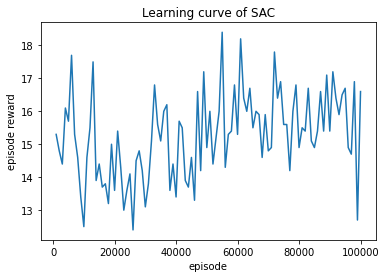

In [19]:
# may need more interactions to converge
log_path = sorted(glob("d3rlpy_logs/SAC_online_*/evaluation.csv"))[-1]
df = pd.read_csv(
    log_path, 
    usecols=[1,2],
    names=["train_episode", "episodic_rewards"]
)
plt.plot(df["train_episode"], df["episodic_rewards"])
plt.title("Learning curve of SAC")
plt.xlabel("episode")
plt.ylabel("episode reward")

In [20]:
random = ContinuousRandomPolicy(
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # minimum value that policy can take
        maximum=env.action_space.high,  # maximum value that policy can take
    )
)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

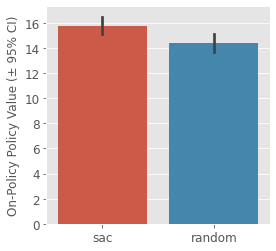

In [21]:
# compare performance online
visualize_on_policy_policy_value(
    env=env,
    policies=[sac, random],
    policy_names=["sac", "random"],
    n_episodes=100,
    random_state=random_state,
)

In [22]:
# on-policy policy value by sac policy
# slightly improves random policy
sac_performance = calc_on_policy_policy_value(env, sac, n_episodes=100, random_state=random_state)
random_performance = calc_on_policy_policy_value(env, random, n_episodes=100, random_state=random_state)
print("relative improvement:", (sac_performance - random_performance) / random_performance)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

relative improvement: 0.09756097560975613


## 1. Synthetic Dataset Generation
In the previous section, we see how we can interact the environment *online* using synthetic simulator.  
Though simulation is a good start for training agent, eventually we want to deploy our agent (or policy) in the real world environment.  
However, online interaction may have potential risk of failure in real-world implementataion.  
Therefore, we introduce alternative learning protocol, Offline RL, which aim to obtain a new policy using only offline logged dataset.

We prepare easy-to-use synthetic dataset generator: `SyntheticDataset` class in the dataset module.  
By regarding simulation environment as a hypothetical real-environment, we show how to conduct Offline RL using logged dataset in real-world application.  
For detailed description of how to use real-world dataset, please see #TODO (will be implemented).

We have following arguments for `SyntheticDataset` class:
- `env`: RTB environment for RL defined in the previous section.
- `bahavior_policy`: RL agent (or algorithm) used for the data collection.
- `n_samples_pretrain_reward_predictor`: Numbers of samples used to pretrain reward predictor.

In [48]:
behavior_policy = ContinuousTruncatedGaussianHead(
    sac, 
    minimum=env.action_space.low,
    maximum=env.action_space.high,
    sigma=np.array([1.0]),
    name="sac_sigma_1.0",
    random_state=random_state,
)

In [49]:
# initialize dataset class
dataset = SyntheticDataset(
    env=env,
    behavior_policy=behavior_policy,
    random_state=random_state,
)

In [50]:
# collect logged data using behavior policy
# skip if there is a preserved logged dataset
logged_dataset = dataset.obtain_trajectories(n_episodes=10000, obtain_info=True)

[obtain_trajectories]:   0%|          | 0/10000 [00:00<?, ?it/s]

In [51]:
logged_dataset

{'size': 70000,
 'n_episodes': 10000,
 'step_per_episode': 7,
 'action_type': 'continuous',
 'n_actions': None,
 'action_dim': 1,
 'action_meaning': None,
 'state_dim': 7,
 'state_keys': ['timestep',
  'remaining_budget',
  'budget_consumption_rate',
  'cost_per_mille_of_impression',
  'winning_rate',
  'reward',
  'adjust_rate'],
 'state': array([[0.00000000e+00, 3.00000000e+03, 9.29616093e-01, ...,
         1.83918812e-01, 2.00000000e+00, 3.87159849e-01],
        [1.00000000e+00, 1.91000000e+03, 3.63333333e-01, ...,
         1.00000000e+00, 6.00000000e+00, 9.49214724e+00],
        [2.00000000e+00, 1.17300000e+03, 3.85863874e-01, ...,
         1.00000000e+00, 1.00000000e+00, 2.26390252e+00],
        ...,
        [4.00000000e+00, 3.00000000e+01, 9.40119760e-01, ...,
         5.50724638e-01, 2.00000000e+00, 1.65485241e+00],
        [5.00000000e+00, 3.00000000e+01, 0.00000000e+00, ...,
         4.92610837e-03, 0.00000000e+00, 1.60074139e+00],
        [6.00000000e+00, 3.00000000e+01, 0.00

In [52]:
with open("logs/dataset_continuous.pkl", "wb") as f:
    pickle.dump(logged_dataset, f)

In [53]:
with open("logs/dataset_continuous.pkl", "rb") as f:
    logged_dataset = pickle.load(f)

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

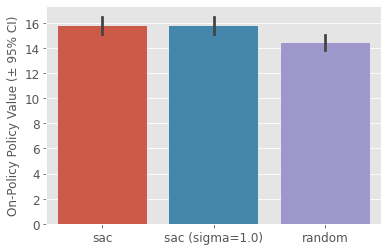

In [54]:
# compare performance online
visualize_on_policy_policy_value(
    env=env,
    policies=[sac, behavior_policy, random],
    policy_names=["sac", "sac (sigma=1.0)", "random"],
    n_episodes=100,
    random_state=random_state,
)

In [55]:
# check statistics of the dataset
df = pd.DataFrame()
df['adjust rate'] = logged_dataset['state'][:, 6]
df['average bid price'] = logged_dataset['info']['average_bid_price']
df['impression'] = logged_dataset['info']['impression']
df['click'] = logged_dataset['info']['click']
df['conversion'] = logged_dataset['info']['conversion']
df['winning rate'] = logged_dataset['state'][:, 4]
df['click / impression'] = df['click'] / (df['impression'] + 1e-5)
df['conversion / click'] = df['conversion'] / (df['click'] + 1e-5)
df.describe()

,adjust rate,average bid price,impression,click,conversion,winning rate,click / impression,conversion / click
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,3.194063,179.347854,89.702357,8.915529,2.229829,0.509389,0.072034,0.150001
std,3.431126,183.468914,84.754666,9.144125,3.052006,0.404692,0.075173,0.188997
min,0.000036,3.951020,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.703310,43.303209,6.000000,0.000000,0.000000,0.064677,0.000000,0.000000
50%,1.480710,87.265766,61.000000,6.000000,1.000000,0.502688,0.081197,0.083333
75%,5.841337,324.019395,180.000000,17.000000,4.000000,0.989011,0.111111,0.250000
max,11.840452,579.532609,290.000000,41.000000,20.000000,1.000000,0.999995,0.999998


## 2. Offline Reinforcement Learning
In this section, we learn a new policy in an offline manner, without interacting to the environment.  
To achieve this goal, we exploit logged dataset and train the policy on the data.  
We use [d3rlpy](https://github.com/takuseno/d3rlpy)'s implementation of algorithms.

In [56]:
# import modules from d3rlpy
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import CQL as ContinuousCQL
from d3rlpy.ope import FQE as ContinuousFQE
from d3rlpy.metrics.scorer import evaluate_on_environment

In [57]:
offlinerl_dataset = MDPDataset(
    observations=logged_dataset["state"],
    actions=logged_dataset["action"],
    rewards=logged_dataset["reward"],
    terminals=logged_dataset["done"],
    episode_terminals=logged_dataset["done"],
    discrete_action=False,
)
train_episodes, test_episodes = train_test_split(offlinerl_dataset, test_size=0.2, random_state=random_state)

In [58]:
# Use Conservetive Q-Learning policy
cql = ContinuousCQL(
    actor_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    critic_encoder_factory=VectorEncoderFactory(hidden_units=[30, 30]),
    q_func_factory=MeanQFunctionFactory(),
    use_gpu=torch.cuda.is_available(),
    action_scaler=MinMaxActionScaler(
        minimum=env.action_space.low,  # minimum value that policy can take
        maximum=env.action_space.high,  # maximum value that policy can take
    )
)

In [59]:
cql.fit(
    train_episodes,
    eval_episodes=test_episodes,
    n_steps=10000,
    scorers={
        'environment': evaluate_on_environment(env),
        # to record training process w/ ground truth policy value, which is unseen to the agent
    },
)

2021-12-23 14:25.43 [debug    ] RandomIterator is selected.
2021-12-23 14:25.43 [info     ] Directory is created at d3rlpy_logs/CQL_20211223142543
2021-12-23 14:25.43 [debug    ] Fitting action scaler...       action_scaler=min_max
2021-12-23 14:25.43 [debug    ] Building models...
2021-12-23 14:25.43 [debug    ] Models have been built.
2021-12-23 14:25.43 [info     ] Parameters are saved to d3rlpy_logs/CQL_20211223142543/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'actor_encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'actor_learning_rate': 0.0001, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'alpha_learning_rate': 0.0001, 'alpha_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0,

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2021-12-23 14:28.33 [info     ] CQL_20211223142543: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0007890231609344482, 'time_algorithm_update': 0.015458772993087769, 'temp_loss': -2.5489946915920823, 'temp': 1.0375176810622215, 'alpha_loss': -12.437949562740325, 'alpha': 1.7963230131864547, 'critic_loss': 80.48444729595184, 'actor_loss': 3.91007031126339, 'time_step': 0.016832749795913697, 'environment': 14.1} step=10000
2021-12-23 14:28.33 [info     ] Model parameters are saved to d3rlpy_logs/CQL_20211223142543/model_10000.pt


[(1,
  {'time_sample_batch': 0.0007890231609344482,
   'time_algorithm_update': 0.015458772993087769,
   'temp_loss': -2.5489946915920823,
   'temp': 1.0375176810622215,
   'alpha_loss': -12.437949562740325,
   'alpha': 1.7963230131864547,
   'critic_loss': 80.48444729595184,
   'actor_loss': 3.91007031126339,
   'time_step': 0.016832749795913697,
   'environment': 14.1})]

In [61]:
# save model
cql.save_model("d3rlpy_logs/cql_continuous.pt")

In [62]:
# reload model
cql.build_with_env(env)
cql.load_model("d3rlpy_logs/cql_continuous.pt")

2021-12-23 14:30.20 [warning  ] Parameters will be reinitialized.


[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

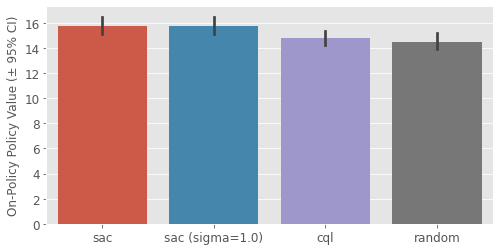

In [63]:
# compare performance online
# wow, offline algorithm outperforms the online algorithm.
# moreover, it requires no interaction to the environment!
visualize_on_policy_policy_value(
    env=env,
    policies=[sac, behavior_policy, cql, random],
    policy_names=["sac", "sac (sigma=1.0)", "cql", "random"],
    n_episodes=100,
    random_state=random_state,
)

## 3. Off-Policy Evaluation and Evaluation of Offline RL methods
In the previous section, we verified the performance of learned policy via online interaction (aka A/B tests).  
However, it could be risky because the policy may perform poorly in an online environment.  
To tackle this issue, we aim to evaluate the performance of policies in an offline manner, to gain prior knowledge on how agent works in the environment.

In [64]:
# import ope modules from _gym
from _gym.ope import CreateOPEInput
from _gym.ope import OffPolicyEvaluation as OPE
from _gym.ope import ContinuousDirectMethod as DM
from _gym.ope import ContinuousTrajectoryWiseImportanceSampling as TIS
from _gym.ope import ContinuousStepWiseImportanceSampling as SIS
from _gym.ope import ContinuousDoublyRobust as DR
from _gym.ope import ContinuousSelfNormalizedTrajectoryWiseImportanceSampling as SNTIS
from _gym.ope import ContinuousSelfNormalizedStepWiseImportanceSampling as SNSIS
from _gym.ope import ContinuousSelfNormalizedDoublyRobust as SNDR
from _gym.policy import ContinuousEvalHead

In [65]:
# define evaluation policies (deterministic policy)
# though OPE is applicable to stochastic policies (i.e., random), the estimation result will be unstable
# because continuous OPE is mainly designed for deterministic policies
cql_ = ContinuousEvalHead(
    base_policy=cql,
    name="cql",
)
sac_ = ContinuousEvalHead(
    base_policy=sac, 
    name="sac", 
)
random_ = ContinuousEvalHead(
    base_policy=random, 
    name="random", 
)
evaluation_policies = [cql_, sac_, random_]

In [66]:
# first, prepare OPE inputs
prep = CreateOPEInput(
    logged_dataset=logged_dataset,
    use_base_model=True,  # use model-based prediction
    base_model_args={
        "encoder_factory": VectorEncoderFactory(hidden_units=[30, 30]),
        "q_func_factory": MeanQFunctionFactory(),
        "learning_rate": 1e-4,
        "use_gpu": torch.cuda.is_available(),
        "action_scaler": MinMaxActionScaler(
            minimum=env.action_space.low,  # minimum value that policy can take
            maximum=env.action_space.high,  # maximum value that policy can take
        ),
    },
)

In [67]:
input_dict = prep.obtain_whole_inputs(
    evaluation_policies=evaluation_policies,
    env=env,
    n_episodes_on_policy_evaluation=100,
    random_state=random_state,
)

[fit FQE model]:   0%|          | 0/3 [00:00<?, ?it/s]

2021-12-23 14:30.32 [debug    ] RandomIterator is selected.
2021-12-23 14:30.32 [info     ] Directory is created at d3rlpy_logs/FQE_20211223143032
2021-12-23 14:30.32 [debug    ] Fitting action scaler...       action_scaler=min_max
2021-12-23 14:30.32 [debug    ] Building models...
2021-12-23 14:30.32 [debug    ] Models have been built.
2021-12-23 14:30.32 [info     ] Parameters are saved to d3rlpy_logs/FQE_20211223143032/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30], 'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None, 'use_dense': False}}, 'gamma': 0.99, 'generated_maxlen': 100000, 'learning_rate': 0.0001, 'n_critics': 1, 'n_frames': 1, 'n_steps': 1, 'optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'q_func_factory': {'type': 'mean', 'params

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2021-12-23 14:30.51 [info     ] FQE_20211223143032: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00034127082824707034, 'time_algorithm_update': 0.0014216299057006835, 'loss': 11.159643758904934, 'time_step': 0.001905488681793213} step=10000
2021-12-23 14:30.51 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20211223143032/model_10000.pt
2021-12-23 14:30.51 [debug    ] RandomIterator is selected.
2021-12-23 14:30.51 [info     ] Directory is created at d3rlpy_logs/FQE_20211223143051
2021-12-23 14:30.51 [debug    ] Fitting action scaler...       action_scaler=min_max
2021-12-23 14:30.51 [debug    ] Building models...
2021-12-23 14:30.51 [debug    ] Models have been built.
2021-12-23 14:30.51 [info     ] Parameters are saved to d3rlpy_logs/FQE_20211223143051/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2021-12-23 14:31.10 [info     ] FQE_20211223143051: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0003249398231506348, 'time_algorithm_update': 0.0013694898128509521, 'loss': 105.53641529201269, 'time_step': 0.0018301390647888183} step=10000
2021-12-23 14:31.10 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20211223143051/model_10000.pt
2021-12-23 14:31.10 [debug    ] RandomIterator is selected.
2021-12-23 14:31.10 [info     ] Directory is created at d3rlpy_logs/FQE_20211223143110
2021-12-23 14:31.10 [debug    ] Fitting action scaler...       action_scaler=min_max
2021-12-23 14:31.10 [debug    ] Building models...
2021-12-23 14:31.10 [debug    ] Models have been built.
2021-12-23 14:31.10 [info     ] Parameters are saved to d3rlpy_logs/FQE_20211223143110/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([0.1]), 'maximum': array([10.])}}, 'batch_size': 100, 'encoder_factory': {'type': 'vector', 'params': {'hidden_units': [30, 30

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2021-12-23 14:31.25 [info     ] FQE_20211223143110: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.00032224528789520266, 'time_algorithm_update': 0.0010952847480773925, 'loss': 9.702057008075714, 'time_step': 0.0015400913476943969} step=10000
2021-12-23 14:31.25 [info     ] Model parameters are saved to d3rlpy_logs/FQE_20211223143110/model_10000.pt


[collect input data]:   0%|          | 0/3 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

[calculate on-policy policy value]:   0%|          | 0/100 [00:00<?, ?it/s]

In [68]:
with open("logs/ope_input_dict_continuous.pkl", "wb") as f:
    pickle.dump(input_dict, f)

In [69]:
with open("logs/ope_input_dict_continuous.pkl", "rb") as f:
    input_dict = pickle.load(f)

In [99]:
ope = OPE(
    logged_dataset=logged_dataset,
    ope_estimators=[
        DM(), 
        TIS(
            action_dim=1,
            use_truncated_kernel=True,
            action_min=env.action_space.low,
            action_max=env.action_space.high,
        ), 
        SIS(
            action_dim=1,
            use_truncated_kernel=True,
            action_min=env.action_space.low,
            action_max=env.action_space.high,
        ), 
        DR(
            action_dim=1,
            use_truncated_kernel=True,
            action_min=env.action_space.low,
            action_max=env.action_space.high,
        ),
        SNTIS(
            action_dim=1,
            use_truncated_kernel=True,
            action_min=env.action_space.low,
            action_max=env.action_space.high,
        ), 
        SNSIS(
            action_dim=1,
            use_truncated_kernel=True,
            action_min=env.action_space.low,
            action_max=env.action_space.high,
        ), 
        SNDR(
            action_dim=1,
            use_truncated_kernel=True,
            action_min=env.action_space.low,
            action_max=env.action_space.high,
        ),
    ],
)

In [102]:
# performance estimation by ope
# takes time to compute
policy_value_df_dict, policy_value_interval_df_dict = ope.summarize_off_policy_estimates(input_dict, random_state=random_state)

In [103]:
# estimated policy performance
policy_value_df_dict

{'cql':            policy_value  relative_policy_value
 on_policy     14.770000               1.000000
 dm             6.094302               0.412614
 tis           15.891003               1.075897
 sis            9.621762               0.651440
 dr            11.839924               0.801620
 sntis         14.785346               1.001039
 snsis         16.625436               1.125622
 sndr          16.731254               1.132786,
 'sac':            policy_value  relative_policy_value
 on_policy     15.750000               1.000000
 dm             6.384321               0.405354
 tis           16.815531               1.067653
 sis            9.576424               0.608027
 dr            11.196284               0.710875
 sntis         15.079724               0.957443
 snsis         15.783113               1.002102
 sndr          14.188075               0.900830,
 'random':            policy_value  relative_policy_value
 on_policy     14.150000               1.000000
 dm           

In [104]:
# estimated policy performance confidence intervals
policy_value_interval_df_dict

{'cql':             mean  95.0% CI (lower)  95.0% CI (upper)
 dm      6.094215          6.093132          6.095888
 tis    16.297109         10.416774         23.207996
 sis     9.671935          9.118333         10.258528
 dr     11.882921         11.510496         12.341505
 sntis  14.880088         13.872910         16.076273
 snsis  16.653802         16.295950         17.045823
 sndr   16.745979         16.495497         17.061392,
 'sac':             mean  95.0% CI (lower)  95.0% CI (upper)
 dm      6.384237          6.383399          6.385084
 tis    16.829967         16.229191         17.418296
 sis     9.588073          9.443092          9.766054
 dr     11.202223         11.105821         11.293935
 sntis  15.200633         14.006179         16.451324
 snsis  15.815431         15.485539         16.141906
 sndr   14.177467         13.842381         14.450936,
 'random':             mean  95.0% CI (lower)  95.0% CI (upper)
 dm      4.983602          4.982087          4.985429
 t

## 4. Evaluation of OPE methods
Now, we evaluate how well ope estimators estimated the policy value.

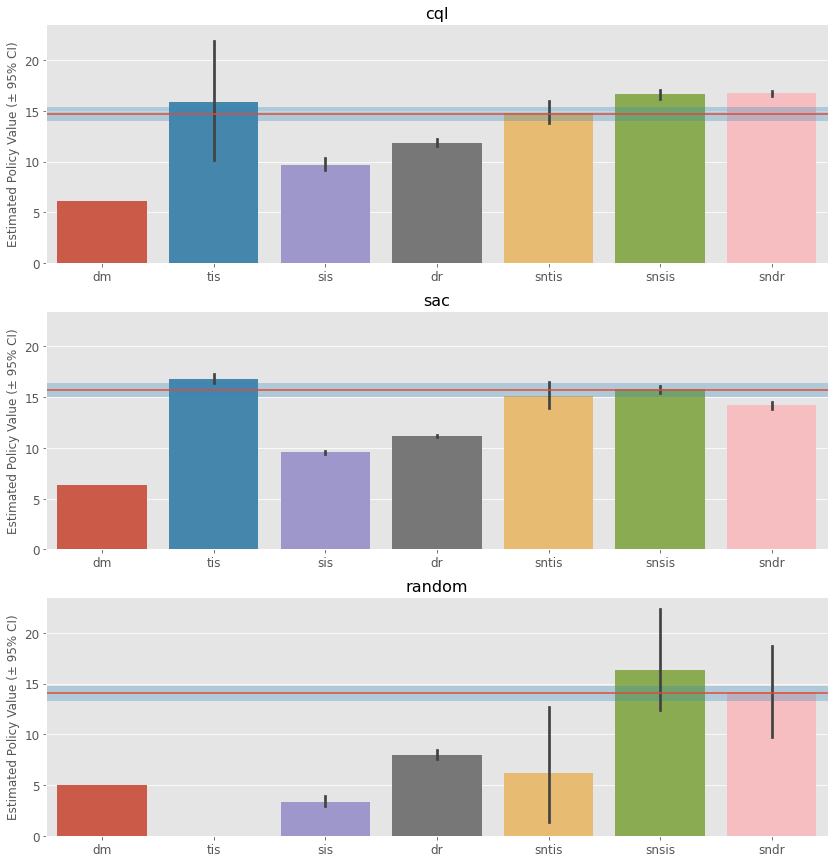

In [105]:
# we can visualize and compare the result
# it seems offline metrics underestimates the policy value
ope.visualize_off_policy_estimates(input_dict, random_state=random_state, sharey=True)

In [106]:
# squared-error (se) measures the estimation accuracy of OPE
eval_metric_ope_df = ope.summarize_estimators_comparison(input_dict, metric="se")
eval_metric_ope_df

,cql,sac,random
dm,75.267741,87.715939,84.022336
tis,1.256649,1.135357,200.139580
sis,26.504359,38.113040,116.498293
dr,8.585346,20.736326,38.172473
sntis,0.000236,0.449271,63.666984
snsis,3.442642,0.001096,4.721043
sndr,3.846519,2.439609,0.001997
